# Assignment 2 Code
<b>Name:</b> Justin Aaron Kelley<br>
<b>Date last modified:</b> 15/05/2021<br>
<b>Runtime:</b> Around 30-35 minutes.

In [64]:
import numpy as np
import statsmodels.api as sm
import pylab as py
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.stats import pearsonr
from sklearn import tree, neighbors
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, chi2

In [65]:
MAX_ITERATIONS = 5000
DEFAULT = 5
ALL = 1
SEPERATOR_MAIN = "###################################################################"
SEPERATOR = "*******************************************************************"

In [66]:
def preprocess(inclusion=ALL, validation_set = True):
    """Takes the raw data for the recipes and the Doc2Vec50 data for them
    and combines them into a single database for both the training and test
    data."""
    
    # Get the Doc2Vec50 data for training and test data.
    trainNameDoc2Vec = pd.read_csv(r"recipe_text_features_doc2vec50/train_name_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
    trainIngrDoc2Vec = pd.read_csv(r"recipe_text_features_doc2vec50/train_ingr_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
    trainStepsDoc2Vec = pd.read_csv(r"recipe_text_features_doc2vec50/train_steps_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
    testNameDoc2Vec = pd.read_csv(r"recipe_text_features_doc2vec50/test_name_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
    testIngrDoc2Vec = pd.read_csv(r"recipe_text_features_doc2vec50/test_ingr_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
    testStepsDoc2Vec = pd.read_csv(r"recipe_text_features_doc2vec50/test_steps_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
    
    
    # Get raw data for training.
    data = pd.read_csv("recipe_train.csv")
    trainData = data[["n_steps", "n_ingredients"]]
    trainLabel = data["duration_label"]

    
    # Get raw data for testing.
    data = pd.read_csv("recipe_test.csv")
    testData = data[["n_steps", "n_ingredients"]]
    
    
    # Combine data for training and testing. The features used depends on the selection.
    # Use all featues by default.
    if inclusion == 1:
        trainTextDoc2Vec = [trainNameDoc2Vec, trainIngrDoc2Vec, trainStepsDoc2Vec, trainData]
        testTextDoc2Vec = [testNameDoc2Vec, testIngrDoc2Vec, testStepsDoc2Vec, testData]
    elif inclusion == 2:
        trainTextDoc2Vec = [trainStepsDoc2Vec]
        testTextDoc2Vec = [testStepsDoc2Vec]
    elif inclusion == 3:
        trainTextDoc2Vec = [trainStepsDoc2Vec, trainData]
        testTextDoc2Vec = [testStepsDoc2Vec, testData]
    elif inclusion == 4:
        trainTextDoc2Vec = [trainNameDoc2Vec, trainIngrDoc2Vec]
        testTextDoc2Vec = [testNameDoc2Vec, testIngrDoc2Vec]
    Xtrain = pd.concat(trainTextDoc2Vec, axis=1)
    Xtest = pd.concat(testTextDoc2Vec, axis=1)
    
    
    # Convert data to numpy arrays.
    Xtrain = Xtrain.to_numpy(dtype=float)
    Xtest = Xtest.to_numpy(dtype=float)
    ytrain = trainLabel.to_numpy(dtype=int)
    

    if validation_set:
        # Split training set further into an unseen test set and a training set to be
        # split into training and validation data.
        X_train, X_unseen_test, y_train, y_unseen_test = train_test_split(Xtrain, ytrain, test_size=0.20, random_state=42)

        return X_train, y_train, X_unseen_test, y_unseen_test, Xtest  
    elif not validation_set:
        return Xtrain, ytrain, Xtest  

In [67]:
def calculateBaseline(Xtrain, Xtest, ytrain, folds=DEFAULT):
    "Uses 0R via cross validation to compute a baseline score for this data."
    
    # Perform 0R.
    clf = DummyClassifier(strategy="most_frequent").fit(Xtrain, ytrain)
    
    # Compute score and confusin matrix.
    return sum(cross_val_score(clf, Xtrain, ytrain, cv=DEFAULT, scoring="accuracy")) / folds

In [68]:
def calculateBenchmark(Xtrain, Xtest, ytrain, folds=DEFAULT):
    "Uses 1R via cross validation to compute a benchmark score for this data."
    
    # Perform 1R.
    clf = tree.DecisionTreeClassifier(max_depth=1).fit(Xtrain, ytrain)
    
    # Compute score and confusin matrix.
    return sum(cross_val_score(clf, Xtrain, ytrain, cv=DEFAULT, scoring="accuracy")) / folds

In [69]:
def Logistic(Xtrain, Xtest, ytrain, ytest, max_iterations=MAX_ITERATIONS):
    """Uses the Logistic Regression model on the data. Returns the score
    and a confusion matrix."""
    
    # Set up model.
    clf = LogisticRegression(random_state=0, max_iter = max_iterations).fit(Xtrain, ytrain)
    
     # Compute score and confusin matrix.
    return clf.score(Xtest, ytest), plot_confusion_matrix(clf, Xtest, ytest, normalize = 'true')

In [70]:
def GaussianNaiveBayes(Xtrain, Xtest, ytrain, ytest):
    """Uses the Gaussian Naive Bayes model on the data. Returns the score
    and a confusion matrix."""
    
    # Set up model.
    clf = GaussianNB().fit(Xtrain, ytrain)
    
    # Compute score and confusin matrix.
    return clf.score(Xtest, ytest), plot_confusion_matrix(clf, Xtest, ytest, normalize = 'true')

In [71]:
def KNN(Xtrain, Xtest, ytrain, ytest, n_neighbors=DEFAULT, weight="distance", dis_metric="minkowski"):
    """Uses the K nearest neighbours model on the data. Returns the score
    and a confusion matrix."""
    
    # Set up model.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weight, metric=dis_metric).fit(Xtrain, ytrain)
    
    # Compute score and confusin matrix.
    return clf.score(Xtest, ytest), plot_confusion_matrix(clf, Xtest, ytest, normalize = 'true')

In [72]:
def baseResults():
    """Compares the three models when using all features.
    Shows the accuracy scores and confusion matrices for each model."""
    
    # Get and process training and validation data from files. 
    Xtrain, ytrain = preprocess()[0:2]
    X_train, X_validation, y_train, y_validation = train_test_split(Xtrain, ytrain, test_size=0.33, random_state=42)
    
    
    # Get counts for each class label.
    print(SEPERATOR_MAIN)
    print("Output for baseResults()")
    print(SEPERATOR_MAIN)
    counts = {1: 0, 2: 0, 3: 0}
    for i in y_train:
        counts[i] += 1
    for i in counts.keys():
        print(f"For label {i} we have {counts[i]} instances.")
    
    
    # Compute accuracy scores, times and confusion matrices.
    print(SEPERATOR_MAIN)
    print("The following are the confusion matrices and accuracy scores for all four methods when trained")
    print("using all features:")
    print(SEPERATOR)
    
    start = datetime.now()
    results = KNN(X_train, X_validation, y_train, y_validation)
    difference = (datetime.now() - start).total_seconds()
    print(f"For KNN, score is {round(results[0], 3)} with time {difference}.")
    plt.title("Normalized Confusion Matrix KNN")
    plt.show()
    print(SEPERATOR)
    
    start = datetime.now()
    results = GaussianNaiveBayes(X_train, X_validation, y_train, y_validation)
    difference = (datetime.now() - start).total_seconds()
    print(f"For Gaussian Naive Bayes, score is {round(results[0], 3)} with time {difference}.")
    plt.title("Normalized Confusion Matrix GNB")
    plt.show()
    print(SEPERATOR)
    
    start = datetime.now()
    results = Logistic(X_train, X_validation, y_train, y_validation)
    difference = (datetime.now() - start).total_seconds()
    print(f"For Logistic Regression, score is {round(results[0], 3)} with time {difference}.")
    plt.title("Normalized Confusion Matrix LR")
    plt.show()
    print(SEPERATOR_MAIN)
    
    
    return 0

In [73]:
def checkAssumptionsGaussianNB():
    """Runs an analysis on the Gaussian Naive Bayes model by examining
    indepedence and normal distribution assumptions."""
    
    # Get and process training and validation data from files. 
    Xtrain, ytrain = preprocess()[0:2]
    X_train, X_validation, y_train, y_validation = train_test_split(Xtrain, ytrain, test_size=0.33, random_state=42)
    
    
    # Construct QQ-plots for several features.
    print(SEPERATOR_MAIN)
    print("Output for checkAssumptionsGaussianNB()")
    print(SEPERATOR_MAIN)
    for i in [0, 10, 20, 30, 50, 60, 70, 80, 100, 110, 120, 130, 150, 151]:
        sm.qqplot(X_train[:,i], line ='45')
        if i < 50:
            plt.title(f"Feature Vector {i + 1} from Doc2Vec50 Format for Recipe Name Feature")
        elif i < 100:
            plt.title(f"Feature Vector {i + 1 - 50} from Doc2Vec50 Format for Recipe Ingredients Feature")
        elif i < 150:
            plt.title(f"Feature Vector {i + 1 - 100} from Doc2Vec50 Format for Recipe Steps Feature")
        elif i == 150:
            plt.title("N_steps Feature compared to Normal Distribution")
        elif i == 151:
            plt.title("N_ingredients Feature compared to Normal Distribution")
        py.show()
    print(SEPERATOR)
    
    
    # Group instances by class.
    X1 = None
    X2 = None
    X3 = None
    for i in range(0, len(y_train)):
        if y_train[i] == 1:
            if X1 is None:
                X1 = np.array([X_train[i,:]])
            else:
                X1 = np.concatenate([X1, np.array([X_train[i,:]])])
        elif y_train[i] == 2:
            if X2 is None:
                X2 = np.array([X_train[i,:]])
            else:
                X2 = np.concatenate([X2, np.array([X_train[i,:]])])
        elif y_train[i] == 3:
            if X3 is None:
                X3 = np.array([X_train[i,:]])
            else:
                X3 = np.concatenate([X3, np.array([X_train[i,:]])])
    X = [X1, X2, X3]
    
    
    # Compute Pearson correlation between features for each class.
    for k in range(len(X)):
        x = X[k]
        count_lower = 0
        count_upper = 0
        total = 0
        for i in range(0, 152):
            for j in range(i, 152):
                total += 1
                pearson = abs(pearsonr(x[:, i], x[:, j])[0])
                if pearson > 0.2:
                    count_lower += 1
                    if pearson > 0.4:
                        count_upper += 1
        print(SEPERATOR)
        print(f"Out of {total} pairings of the features, {count_lower} have an absolute correlation above 0.2, while")
        print(f"{count_upper} have one above 0.4 for class {k + 1}.")

    
    # Calculate accuracy of model when using all features.
    print(SEPERATOR)
    results = GaussianNaiveBayes(X_train, X_validation, y_train, y_validation)
    print(f"Gaussian Naive Bayes has an accuracy score of {round(results[0], 3)} when tested using all features on training")
    print("set. Below is the confusion matrix:")
    plt.show()
    print(SEPERATOR)
    
    
    # Rerun model using only Doc2Vec50 data from steps feature.
    print("Now we rerun the model using only Doc2Vec50 data from the steps feature")
    print("which appeared to be the set of data to be normally distributed.")
    Xtrain, ytrain = preprocess(inclusion=2)[0:2]
    X_train, X_validation, y_train, y_validation = train_test_split(Xtrain, ytrain, test_size=0.33, random_state=42)
    results = GaussianNaiveBayes(X_train, X_validation, y_train, y_validation)
    print(f"The score is {round(results[0], 3)} with confusion matrix:")
    plt.show()
    print(SEPERATOR_MAIN)
    
    
    return 0

In [74]:
def studyParametersKNN():
    """Performs an analysis on the KNN model by seeing how it performs with all features, after feature
    reduction and by varying the voting method and number of nearest neighbours."""
    
    # Get and process training and validation data from files. 
    Xtrain, ytrain = preprocess()[0:2]
    X_train, X_validation, y_train, y_validation = train_test_split(Xtrain, ytrain, test_size=0.33, random_state=42)
    
    
    # Calculate accuracy of model when using majority voting.
    results = KNN(X_train, X_validation, y_train, y_validation, weight="uniform")
    print(f"KNN has an accuracy score of {round(results[0], 3)} when tested using all features on training")
    print("set with majority voting and 5 nearest neighbours.")
    plt.title("Normalized Confusion matrix")
    plt.show()
    print(SEPERATOR)
    
    
    # Compare model accuracy over different number of nearest neighbours and check for overfitting.
    train = []
    test = []
    K_values = [i for i in range(1, 35, 5)]
    print("The following shows the accuracy of KNN over different numbers of nearest neighbours:")
    for i in K_values:
        results = KNN(X_train, X_validation, y_train, y_validation, n_neighbors=i)
        print(f"When we have {i} nearest neighbours, the score is {round(results[0], 3)} with confusion matrix:")
        plt.title("Normalized Confusion matrix")
        plt.show()
        
        # Collect data to check for overfitting.
        test.append(results[0])
        train.append(KNN(X_train, X_train, y_train, y_train, i)[0])
        plt.clf()
        plt.close()
    print(SEPERATOR)
    
    
    # Print learning curve over different number of nearest neighbours.
    print("This curve shows the accuracy scores when tested using both training and validation sets")
    print("via random holdout.")
    plt.cla()
    plt.plot(K_values, train, color="blue", label = "Train", marker='x')
    plt.plot(K_values, test, color="green", label = "Test", marker='x')
    plt.legend()
    plt.title("Training and Validation Accuracy Rates for Different Values of K")
    plt.xlabel("K value")
    plt.ylabel("Accuracy score")
    plt.show()
    print(SEPERATOR_MAIN) 
    
    return 0

In [75]:
def featureSelection():
    """Compares all three models when performing feature selection via feature
    flitering using mutual information to select the k best features. Runs this
    over several values of k."""

    # Get and process training and validation data from files. 
    Xtrain, ytrain = preprocess()[0:2]
    X_train, X_validation, y_train, y_validation = train_test_split(Xtrain, ytrain, test_size=0.33, random_state=42)
    
    
    print(SEPERATOR_MAIN)
    print("Output for featureSelection()")
    print(SEPERATOR_MAIN)
    print("The following are the accuracy scores for all three methods when trained")
    print("using K best features over different K values using mutual information.")
      
    # Run models over different best k features using mutual information.
    for i in [10, 30, 50, 70, 90, 110, 130]:
        
        # Select best k values using mutual information.
        mi = SelectKBest(mutual_info_classif, k=i)
        X_train_mi = mi.fit_transform(X_train,y_train)
        X_validation_mi = mi.transform(X_validation)

        # Compute accuracy scores for models.
        scoreLR = LogisticRegression(random_state=0, max_iter=5000).fit(X_train_mi, y_train).score(X_validation_mi, y_validation)
        scoreKNN = neighbors.KNeighborsClassifier(11, weights="distance").fit(X_train_mi, y_train).score(X_validation_mi, y_validation)
        scoreGNB = GaussianNB().fit(X_train_mi, y_train).score(X_validation_mi, y_validation)
        
        # Display scores.
        print(SEPERATOR)
        print(f"When k is {i} we have the following scores:")
        print(f"For LR, score is {round(scoreLR, 3)}.")
        print(f"For KNN, score is {round(scoreKNN, 3)}.")
        print(f"For GNB, score is {round(scoreGNB, 3)}.")
    print(SEPERATOR_MAIN)

    return 0

In [76]:
def generateLearningCurves():
    """Constructs a learning curve over different random holdout splits for
    each of the three models."""
    
    # Get and process training and validation data from files. 
    Xtrain, ytrain = preprocess()[0:2] 
    
    
    
    # Generate models.
    clf1 = LogisticRegression(random_state=0, max_iter=5000)
    clf2 = neighbors.KNeighborsClassifier(11, weights="distance")
    clf3 = GaussianNB()
    models = [clf1, clf2, clf3]
    titles = ["LR", "KNN", "GNB"]
    
    
    # For each model generate a learning curve.
    print(SEPERATOR_MAIN)
    print("Output for generateLearningCurves()")
    print(SEPERATOR_MAIN)
    print("The following are learning curves for each model over")
    print("different random splits using random holdout.")
    for i in range(0, len(models)):
        train = []
        validation = []
        states = [i for i in range(1, 15, 1)]
        
        # Generate learning curve for the model.
        for j in states:
            X_train, X_validation, y_train, y_validation = train_test_split(Xtrain, ytrain, test_size=0.33, random_state=j)
            # Use feature filtering for GNB.
            if i == 2:
                mi = SelectKBest(mutual_info_classif, k=30)
                X_train = mi.fit_transform(X_train, y_train)
                X_validation = mi.transform(X_validation)
            
            validation.append(models[i].fit(X_train, y_train).score(X_validation, y_validation))
            train.append(models[i].fit(X_train, y_train).score(X_train, y_train))
        plt.cla()
        plt.plot(states, train, color="blue", label = "Train", marker='x')
        plt.plot(states, validation, color="green", label = "Validation", marker='x')
        plt.legend()
        plt.title(f"Training and Validation Accuracy Scores Over Random Train/Validation Splits for {titles[i]}")
        plt.xlabel("Random State in Scikit-learn train_test_split function")
        plt.ylabel("Accuracy score")
        plt.show()
    print(SEPERATOR_MAIN)                 

    return 0

In [77]:
def makePredictions():
    """Use each model to make predictions on the test set.
    Outputs these as CSV files."""
   
    # Process training and test data from files.
    Xtrain, ytrain, Xtest = preprocess(validation_set = False)
    
    # Make predictions for logistic regression.
    logistic = LogisticRegression(random_state=0, max_iter = 5000).fit(Xtrain, ytrain).predict(Xtest)
    
    # Make predictions for KNN.
    knn = neighbors.KNeighborsClassifier(n_neighbors=11, weights="distance").fit(Xtrain, ytrain).predict(Xtest)
    
    # Make predictions for Gaussian Naive Bayes.
    mi = SelectKBest(mutual_info_classif, k=30)
    Xtrain_mi = mi.fit_transform(Xtrain, ytrain)
    Xtest_mi = mi.transform(Xtest)
    gaussian = GaussianNB().fit(Xtrain_mi, ytrain).predict(Xtest_mi)
    
    # Store predictions in a list and names for their CSV file names.
    predictions = [logistic, gaussian, knn]
    titles = ["logisticPredictions.csv", "gaussianPredictions.csv", "KNNPredictions.csv"]
       
    # Output predictions as CSV files.
    for i in range(0, len(titles)):
        predict = np.array(predictions[i], dtype = 'f')
        data = pd.DataFrame(data=predict, columns=["duration_label"])
        data.index = np.arange(1, len(data) + 1)
        data.index.name = "id"
        data.to_csv(titles[i])

    return 0

In [78]:
def showResultsForEachModel():
    """Shows the performance of each model using cross validation."""
    
    # Get and process training, test and validation data from files. 
    Xtrain, ytrain, Xtest, ytest = preprocess()[0:4]
    X_train, X_validation, y_train, y_validation = train_test_split(Xtrain, ytrain, test_size=0.33, random_state=42)
    
    # Define classifiers.
    clf1 = LogisticRegression(random_state=0, max_iter=5000)
    clf2 = neighbors.KNeighborsClassifier(11, weights="distance")
    clf3 = GaussianNB()
   
    classifiers = [clf1, clf2, clf3]
    titles = ["Logistic Regression", "KNN", "Gaussian Naive Bayes"]
    
    # Compute best 30 features using mutual information to be used by GNB.
    mi = SelectKBest(mutual_info_classif, k=30)
    X_train_mi = mi.fit_transform(X_train, y_train)
    X_test_mi = mi.transform(Xtest)
    
    # Compute accuracy scores and confusion matrices.
    print(SEPERATOR_MAIN)
    print("Output for showResultsForEachModel()")
    print(SEPERATOR_MAIN)
    print("The following are the accuracy scores for all final three methods when trained")
    print("using all features:")
    for i in range(0, len(classifiers)):
        if i != 2:
            score = classifiers[i].fit(X_train, y_train).score(Xtest, ytest)
        else:
            score = classifiers[i].fit(X_train_mi, y_train).score(X_test_mi, ytest)
        print(f"For {titles[i]}, score is {round(score, 3)}")
    print(SEPERATOR_MAIN)
    
    return 0 

Baseline measure using 0R is: 0.621.
Benchmark measure using 1R is: 0.506.
###################################################################
Output for baseResults()
###################################################################
For label 1 we have 9502 instances.
For label 2 we have 10837 instances.
For label 3 we have 1101 instances.
###################################################################
The following are the confusion matrices and accuracy scores for all four methods when trained
using all features:
*******************************************************************
For KNN, score is 0.678 with time 17.169266.


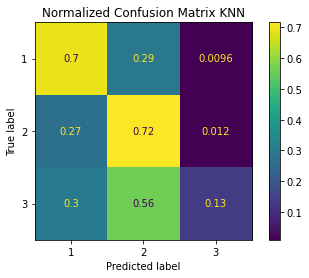

*******************************************************************
For Gaussian Naive Bayes, score is 0.627 with time 0.415484.


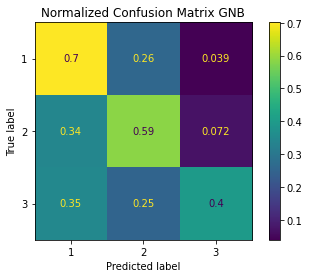

*******************************************************************
For Logistic Regression, score is 0.721 with time 10.06806.


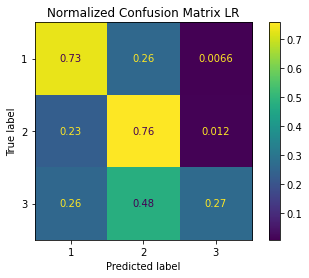

###################################################################
###################################################################
Output for checkAssumptionsGaussianNB()
###################################################################


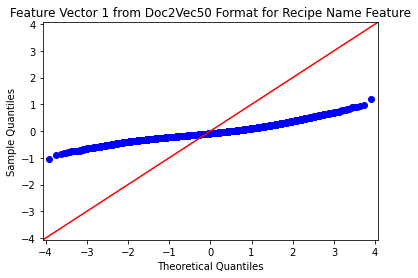

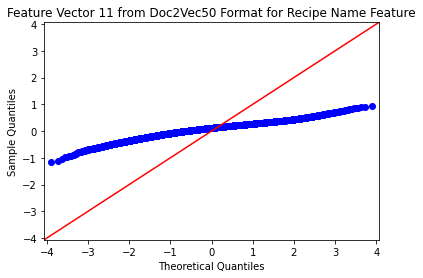

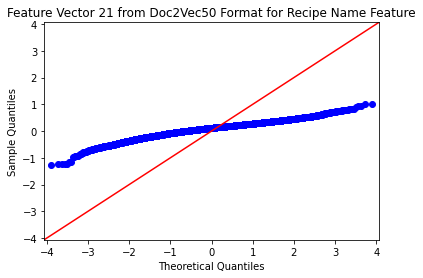

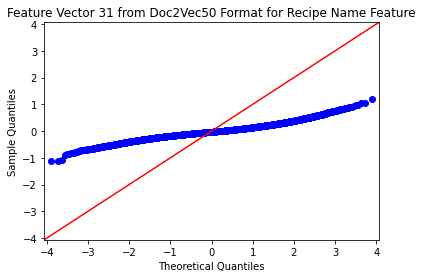

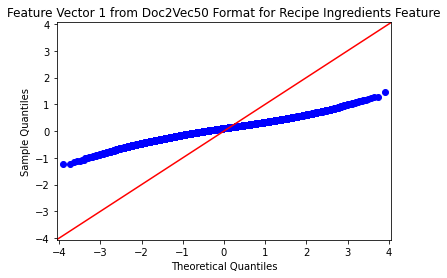

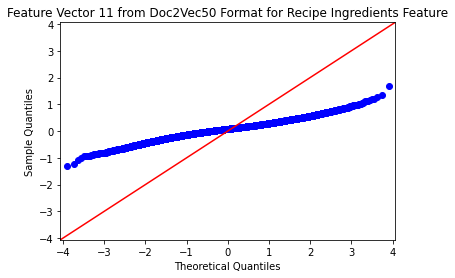

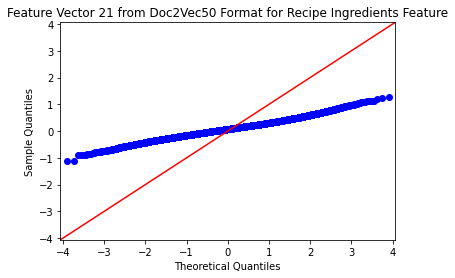

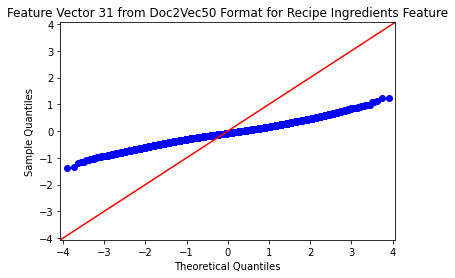

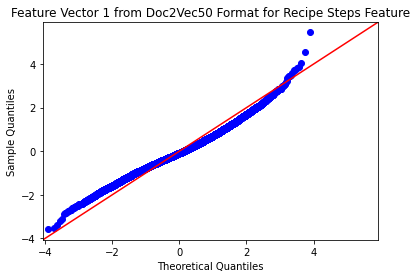

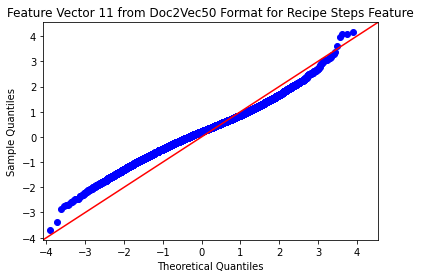

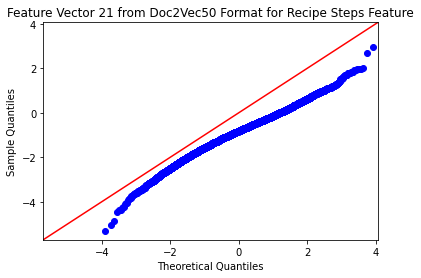

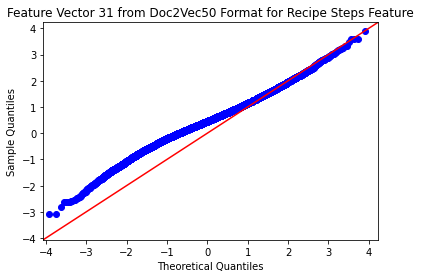

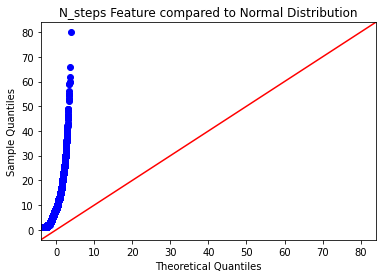

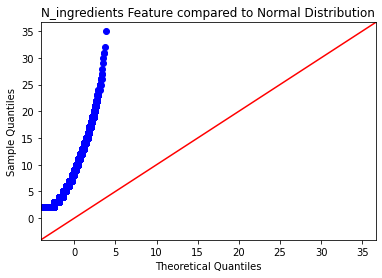

*******************************************************************
*******************************************************************
Out of 11628 pairings of the features, 296 have an absolute correlation above 0.2, while
152 have one above 0.4 for class 1.
*******************************************************************
Out of 11628 pairings of the features, 330 have an absolute correlation above 0.2, while
152 have one above 0.4 for class 2.
*******************************************************************
Out of 11628 pairings of the features, 382 have an absolute correlation above 0.2, while
152 have one above 0.4 for class 3.
*******************************************************************
Gaussian Naive Bayes has an accuracy score of 0.627 when tested using all features on training
set. Below is the confusion matrix:


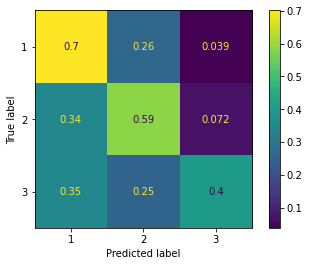

*******************************************************************
Now we rerun the model using only Doc2Vec50 data from the steps feature
which appeared to be the set of data to be normally distributed.
The score is 0.622 with confusion matrix:


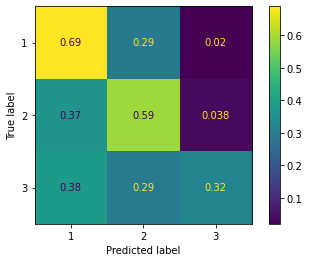

###################################################################
KNN has an accuracy score of 0.678 when tested using all features on training
set with majority voting and 5 nearest neighbours.


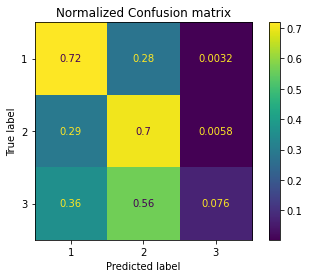

*******************************************************************
The following shows the accuracy of KNN over different numbers of nearest neighbours:
When we have 1 nearest neighbours, the score is 0.622 with confusion matrix:


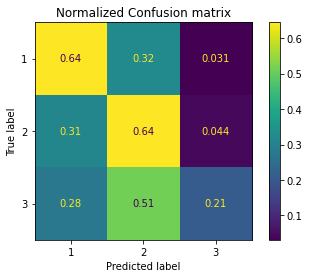

When we have 6 nearest neighbours, the score is 0.684 with confusion matrix:


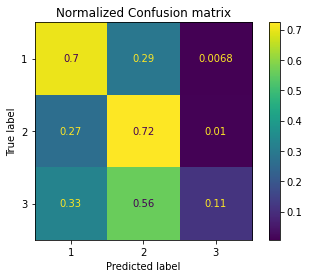

When we have 11 nearest neighbours, the score is 0.698 with confusion matrix:


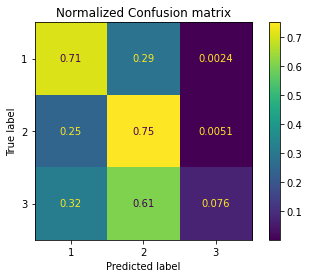

When we have 16 nearest neighbours, the score is 0.701 with confusion matrix:


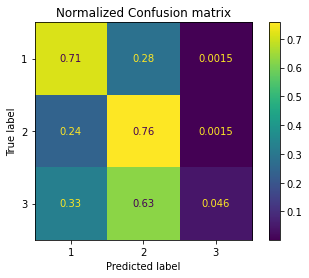

When we have 21 nearest neighbours, the score is 0.705 with confusion matrix:


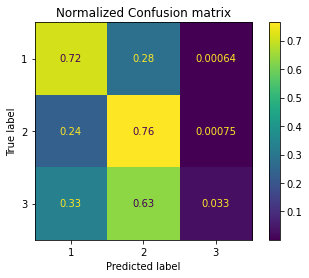

When we have 26 nearest neighbours, the score is 0.706 with confusion matrix:


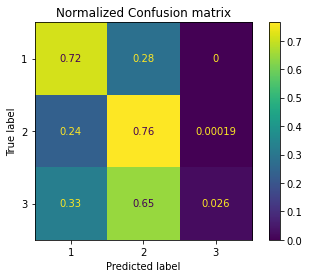

When we have 31 nearest neighbours, the score is 0.707 with confusion matrix:


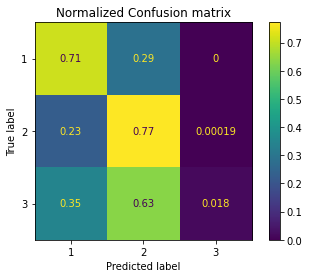

*******************************************************************
This curve shows the accuracy scores when tested using both training and validation sets
via random holdout.


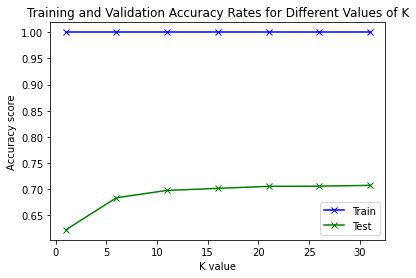

###################################################################
###################################################################
Output for featureSelection()
###################################################################
The following are the accuracy scores for all three methods when trained
using K best features over different K values using mutual information.
*******************************************************************
When k is 10 we have the following scores:
For LR, score is 0.688.
For KNN, score is 0.666.
For GNB, score is 0.654.
*******************************************************************
When k is 30 we have the following scores:
For LR, score is 0.707.
For KNN, score is 0.681.
For GNB, score is 0.659.
*******************************************************************
When k is 50 we have the following scores:
For LR, score is 0.711.
For KNN, score is 0.689.
For GNB, score is 0.646.
******************************************************************

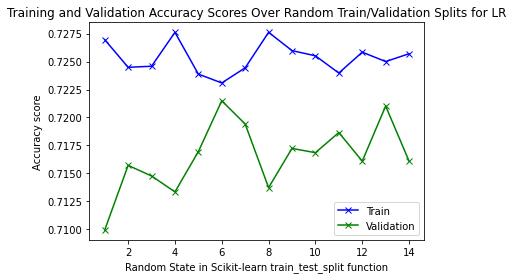

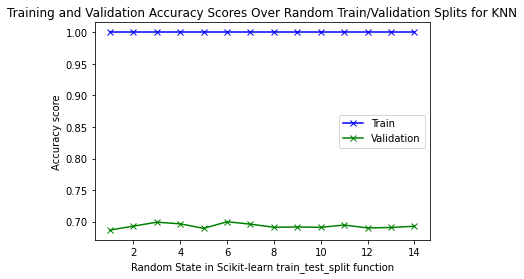

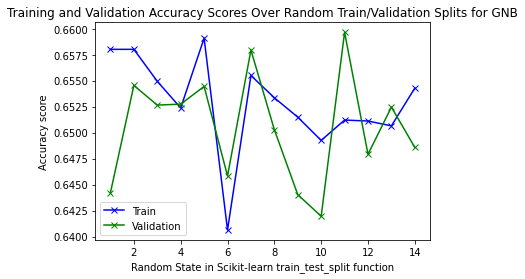

###################################################################
###################################################################
Output for showResultsForEachModel()
###################################################################
The following are the accuracy scores for all final three methods when trained
using all features:
For Logistic Regression, score is 0.715
For KNN, score is 0.688
For Gaussian Naive Bayes, score is 0.644
###################################################################


0

In [79]:
def runProgram():
    """Runs the overall program."""
    
    # Process and get the training and testing sets from the files.
    Xtrain, ytrain, Xtest = preprocess(validation_set = False)
    X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.33, random_state=42)
    
    # Compute baseline and benchmark measures.
    print(f"Baseline measure using 0R is: {round(calculateBenchmark(Xtrain, Xtest, ytrain), 3)}.")
    print(f"Benchmark measure using 1R is: {round(calculateBaseline(Xtrain, Xtest, ytrain), 3)}.")

    # Runs the functions that performs the analysis code on the four models.
    baseResults()
    checkAssumptionsGaussianNB()
    studyParametersKNN()
    featureSelection()
    generateLearningCurves()
    
    # Show final accuracy scores for each model.
    showResultsForEachModel()
    
    # Make the predictions.
    makePredictions()
    
    return 0

runProgram()    